# **RosbagInputFormat** 
RosbagInputFormat is an open source **splitable** Hadoop InputFormat for the rosbag file format.
![images/concept.png](images/concept.png)

# Usage from Spark (pyspark)
Example data can be found for instance at https://github.com/udacity/self-driving-car/tree/master/datasets published under MIT License.

## Check that the rosbag file version is V2.0
```bash
java -jar lib/rosbaginputformat_2.11-0.9.0-SNAPSHOT.jar --version -f HMB_1.bag
```

## Extract the index as configuration
The index is a very very small configuration file containing a protobuf array that will be given in the job configuration.

**Note** that the operation **will not** process and it **will not** parse the whole bag file, but will simply seek to the required offset.
```bash
java -jar lib/rosbaginputformat_2.11-0.9.0-SNAPSHOT.jar -f HMB_1.bag
```
This will generate a very small file named HMB_1.bag.idx.bin in the same folder.

## Copy the bag file in HDFS

Using your favorite tool put the bag file in your working HDFS folder.

**Note:** keep the index json file as configuration to your jobs, **do not** put small files in HDFS.

Assuming your HDFS working folder is /user/spark/ (e.g. hdfs dfs -mkdir /user/spark/)
```bash
hdfs dfs -put data/HMB_1.bag
hdfs dfs -ls
```

## Process the ros bag file in Spark using the RosbagInputFormat

Start your Spark (e.g. jupyter notebook)
```bash
PYSPARK_PYTHON=python2 \
PYSPARK_DRIVER_PYTHON=jupyter \
PYSPARK_DRIVER_PYTHON_OPTS=notebook \
/opt/spark/bin/pyspark \
           --num-executors 2 \
           --driver-memory 5g \
           --executor-memory 4g \
           --jars=./lib/rosbaginputformat_2.11-0.9.0-SNAPSHOT.jar
```

**Note:** your HDFS address might differ.
![images/header.png](images/header.png)

In [3]:
fin = sc.newAPIHadoopFile(
    path =             "hdfs://127.0.0.1:9000/user/root/HMB_1.bag",
    inputFormatClass = "de.valtech.foss.RosbagMapInputFormat",
    keyClass =         "org.apache.hadoop.io.LongWritable",
    valueClass =       "org.apache.hadoop.io.MapWritable",
    conf =             {"RosbagInputFormat.chunkIdx":"./HMB_1.bag.idx.bin"})

## Interpret the Messages
To interpret the messages we need the connections.

We could get the connections as configuration as well. At the moment we decided to collect the connections into Spark driver in a dictionary and use it in the subsequent RDD actions. Note in the next version of the RosbagInputFormater alternative implementations will be given.

### Collect the connections from all Spark partitions of the bag file into the Spark driver

In [4]:
conn_a = fin.filter(lambda r: r[1]['header']['op'] == 7).map(lambda r: r[1]).collect()
conn_d = {str(k['header']['topic']):k for k in conn_a}
# see topic names
conn_d.keys()

['/right_camera/camera_info',
 '/fix',
 '/center_camera/image_color/compressed',
 '/ecef/',
 '/vehicle/steering_report',
 '/vehicle/brake_report',
 '/pressure',
 '/vehicle/gps/time',
 '/vehicle/joint_states',
 '/vehicle/suspension_report',
 '/vehicle/sonar_cloud',
 '/velodyne_packets',
 '/vehicle/surround_report',
 '/diagnostics',
 '/vehicle/brake_info_report',
 '/vehicle/imu/data_raw',
 '/time_reference',
 '/vehicle/gear_report',
 '/vehicle/throttle_report',
 '/vehicle/fuel_level_report',
 '/vehicle/gps/vel',
 '/imu/data',
 '/center_camera/camera_info',
 '/vehicle/filtered_accel',
 '/vehicle/wheel_speed_report',
 '/vehicle/twist_controller/parameter_descriptions',
 '/left_camera/image_color/compressed',
 '/can_bus_dbw/can_rx',
 '/vehicle/twist_controller/parameter_updates',
 '/vehicle/throttle_info_report',
 '/right_camera/image_color/compressed',
 '/vehicle/misc_1_report',
 '/vehicle/gps/fix',
 '/vehicle/tire_pressure_report',
 '/left_camera/camera_info',
 '/vehicle/dbw_enabled']

### Load the python map functions from src/main/python/functions.py

In [5]:
%run -i ../src/main/python/functions.py

### Use of msg_map to apply a function on all messages
Python **rosbag.bag** needs to be installed on all Spark workers.
The msg_map function (from src/main/python/functions.py) takes three arguments:
1. r = the message or RDD record Tuple
2. func = a function (default str) to apply to the ROS message
3. conn = a connection to specify what topic to process


In [12]:
from functools import partial
import pandas as pd

ImportError: No module named pandas

In [7]:
# Take messages from '/imu/data' topic using default str func
rdd = fin.flatMap(
    partial(msg_map, conn=conn_d['/imu/data'])
)

print(rdd.take(1)[0])

header: 
  seq: 1183922
  stamp: 
    secs: 1479424214
    nsecs: 778361082
  frame_id: /imu
orientation: 
  x: 0.0129953000777
  y: 0.0285158107904
  z: 0.919372532256
  w: 0.392137603658
orientation_covariance: [0.017453292519943295, 0.0, 0.0, 0.0, 0.017453292519943295, 0.0, 0.0, 0.0, 0.15707963267948966]
angular_velocity: 
  x: 0.0
  y: 0.0
  z: 0.0
angular_velocity_covariance: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
linear_acceleration: 
  x: 0.413850963116
  y: 0.0246856212616
  z: 8.58306980133
linear_acceleration_covariance: [0.0004, 0.0, 0.0, 0.0, 0.0004, 0.0, 0.0, 0.0, 0.0004]


### Image data from camera messages

An example of taking messages using a func other than default str.

In our case we apply a lambda to messages from from '/center_camera/image_color/compressed' topic. As usual with Spark the operation will happen in parallel on all workers.

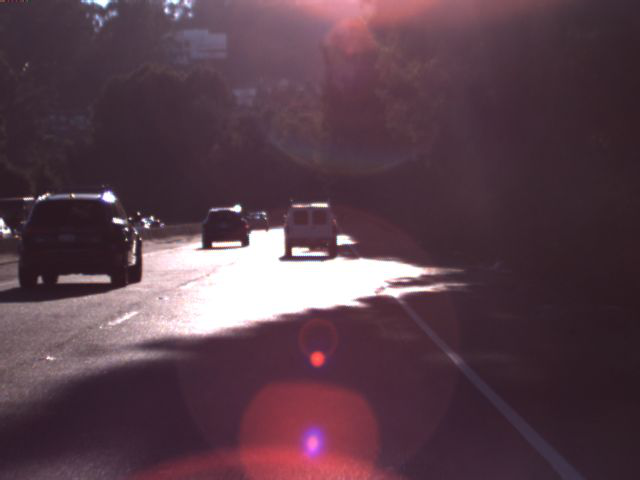

In [7]:
from PIL import Image
from io import BytesIO

res = fin.flatMap(
    partial(msg_map, func=lambda r: r.data, conn=conn_d['/center_camera/image_color/compressed'])
).take(50)
 
Image.open(BytesIO(res[48]))

### Plot fuel level
The topic /vehicle/fuel_level_report contains 2215 ROS messages. Let us plot the header.stamp in seconds vs. fuel_level using a pandas dataframe

In [11]:
def f(msg):
    return (msg.header.stamp.secs, msg.fuel_level)

d = fin.flatMap(
    partial(msg_map, func=f, conn=conn_d['/vehicle/fuel_level_report'])
).toDF().toPandas()

d.set_index('_1').plot()

ImportError: No module named pandas